# Hyperparameter Tuning
In this notebook, we will tune the hyperparameters of our model to find the best model for our data.

In [1]:
# Libraries
import pickle
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import optuna

from scipy.special import inv_boxcox, boxcox
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

# Configurations
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

# Load data
df = pd.read_csv('../data/processed/rent_valencia.csv', index_col=0)
df.head()

,price,numPhotos,floor,rooms,bathrooms,size,parkingSpacePrice,exterior,renew,new_development,hasParkingSpace,isParkingSpaceIncludedInPrice,isFinished,hasLift,hasPlan,has360,has3DTour,hasVideo,propertyType,cluster
propertyCode,,,,,,,,,,,,,,,,,,,,
97942302,850.0,23,0,5,2,140.0,0.0,False,False,False,False,False,True,False,False,False,False,False,countryHouse,3
97956954,900.0,18,1,3,3,100.0,0.0,True,False,False,True,True,True,True,False,False,False,False,duplex,0
98200619,1200.0,26,2,3,2,145.0,0.0,True,False,False,False,False,True,True,False,False,False,False,flat,0
98015046,1800.0,21,0,3,2,103.0,0.0,True,False,False,False,False,True,True,False,False,False,True,flat,0
97530419,850.0,27,5,3,1,76.0,0.0,False,False,False,False,False,True,True,False,False,False,True,flat,0


In [2]:
# Transform cluster to categorical
df['cluster'] = df['cluster'].map({0: 'central', 1: 'south', 2: 'north', 3: 'west'})

# Function to Box-Cox transform a column
def box_cox_transform(column, lamda= None):
    if lamda is None:
        column, lamda = stats.boxcox(column)
        
        return column, lamda
    else:
        column = boxcox(column, lamda)
        return column

def inv_box_cox_transform(column, lamda):
    column = inv_boxcox(column, lamda)
    return column

In [3]:
X = df.drop(['price'], axis=1)
y = df['price']

X_train, X_test, y_train, y_test, train_index, test_index = train_test_split(X, y, df.index, test_size=0.2, random_state=42)

num_col = X_train.select_dtypes(include=['int64', 'float64']).columns
cat_col = X_train.select_dtypes(include=['object']).columns
bool_features = X_train.select_dtypes(include=['bool']).columns

preprocessor = ColumnTransformer(
    [
    ('scaler', StandardScaler(), num_col),
    ('onehot', OneHotEncoder(), cat_col)
    ],
    remainder='passthrough'
)

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)
y_train, lamda = box_cox_transform(y_train)
y_test = box_cox_transform(y_test, lamda)

encoded_cat = preprocessor.named_transformers_['onehot'].get_feature_names_out(cat_col)
labels = np.concatenate([num_col, encoded_cat, bool_features])
df_train = pd.DataFrame(X_train, columns=labels, index=train_index)
df_test = pd.DataFrame(X_test, columns=labels, index=test_index)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3334 entries, 97840274 to 97951630
Data columns (total 27 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   numPhotos                      3334 non-null   float64
 1   floor                          3334 non-null   float64
 2   rooms                          3334 non-null   float64
 3   bathrooms                      3334 non-null   float64
 4   size                           3334 non-null   float64
 5   parkingSpacePrice              3334 non-null   float64
 6   propertyType_chalet            3334 non-null   float64
 7   propertyType_countryHouse      3334 non-null   float64
 8   propertyType_duplex            3334 non-null   float64
 9   propertyType_flat              3334 non-null   float64
 10  propertyType_penthouse         3334 non-null   float64
 11  propertyType_studio            3334 non-null   float64
 12  cluster_central                3334 n

### Random Forest

In [4]:
def rf_objetive(trial):
    criterion = trial.suggest_categorical('criterion', ['squared_error', 'absolute_error'])
    bootstrap = trial.suggest_categorical('bootstrap',['True','False'])
    max_depth = trial.suggest_int('max_depth', 1, 10000)
    max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2'])
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 1, 10000)
    n_estimators =  trial.suggest_int('n_estimators', 30, 1000)
    
    regr = RandomForestRegressor(
        bootstrap = bootstrap, 
        criterion = criterion,
        max_depth = max_depth, 
        max_features = max_features,
        max_leaf_nodes = max_leaf_nodes,
        n_estimators = n_estimators,
        n_jobs=-1
        )
    
    score = cross_val_score(regr, X_train, y_train, cv=5, scoring="r2")
    r2_mean = score.mean()

    return r2_mean

#Execute optuna and set hyperparameters
study = optuna.create_study(direction='maximize')
study.optimize(rf_objetive, n_trials=100)

#Create an instance with tuned hyperparameters
optimised_rf = RandomForestRegressor(
    bootstrap = study.best_params['bootstrap'], 
    criterion = study.best_params['criterion'],
    max_depth = study.best_params['max_depth'], 
    max_features = study.best_params['max_features'],
    max_leaf_nodes = study.best_params['max_leaf_nodes'],
    n_estimators = study.best_params['n_estimators'],
    n_jobs=-1
    )

#learn
optimised_rf.fit(X_train ,y_train)

# Save the model
pickle.dump(optimised_rf, open('../models/rent_valencia_rf.pkl', 'wb'))

[I 2022-08-07 18:29:28,780] A new study created in memory with name: no-name-20175f16-3400-41c6-8432-99c01f8f72b8
[I 2022-08-07 18:30:30,002] Trial 0 finished with value: 0.44025104203007637 and parameters: {'criterion': 'absolute_error', 'bootstrap': 'False', 'max_depth': 9266, 'max_features': 'auto', 'max_leaf_nodes': 2644, 'n_estimators': 571}. Best is trial 0 with value: 0.44025104203007637.
[I 2022-08-07 18:30:34,596] Trial 1 finished with value: 0.4364733291577417 and parameters: {'criterion': 'squared_error', 'bootstrap': 'True', 'max_depth': 7155, 'max_features': 'auto', 'max_leaf_nodes': 3032, 'n_estimators': 482}. Best is trial 0 with value: 0.44025104203007637.
[I 2022-08-07 18:30:39,286] Trial 2 finished with value: 0.4282446864909124 and parameters: {'criterion': 'absolute_error', 'bootstrap': 'False', 'max_depth': 3571, 'max_features': 'auto', 'max_leaf_nodes': 1479, 'n_estimators': 44}. Best is trial 0 with value: 0.44025104203007637.
[I 2022-08-07 18:30:43,644] Trial 3 

In [10]:
# Metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

y_pred = optimised_rf.predict(X_test)
y_pred = inv_box_cox_transform(y_pred, lamda)
y_test = inv_box_cox_transform(y_test, lamda)

print('R2:', r2_score(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))
print('MSE:', mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))

R2: 0.38477504214777747
MAE: 291.4603575217892
MSE: 214799.6998303727
RMSE: 463.4648852182576


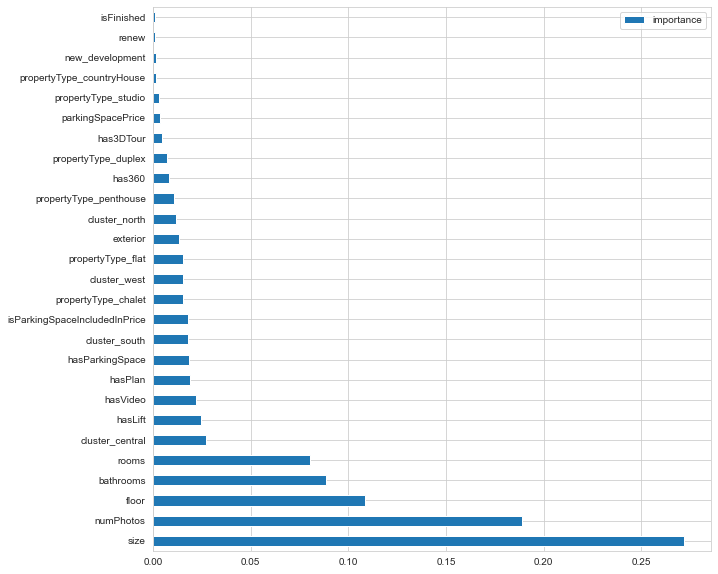

In [17]:
# Plot feature importances
feature_importances = pd.DataFrame(
    optimised_rf.feature_importances_, 
    index=labels, 
    columns=['importance']).sort_values(by='importance', ascending=False)

feature_importances.plot(kind='barh', figsize=(10, 10))
plt.show()

In [69]:
Train = df_train.copy()
Test = df_test.copy()

In [70]:
feature_df = {'feature_droped': [], 'R2': [], 'MAE': [], 'MSE': [], 'RMSE': []}
features = list(feature_importances.index)[5:]

for i in reversed(features):
    Train.drop(i, axis=1, inplace=True)
    Test.drop(i, axis=1, inplace=True)
    
    X_train = Train
    X_test = Test

    optimised_rf.fit(X_train, y_train)
    y_pred = optimised_rf.predict(X_test)
    y_pred = inv_box_cox_transform(y_pred, lamda)

    feature_df['feature_droped'].append(i)
    feature_df['R2'].append(r2_score(y_test, y_pred))
    feature_df['MAE'].append(mean_absolute_error(y_test, y_pred))
    feature_df['MSE'].append(mean_squared_error(y_test, y_pred))
    feature_df['RMSE'].append(np.sqrt(mean_squared_error(y_test, y_pred)))

feature_df = pd.DataFrame(feature_df)
feature_df

,feature_droped,R2,MAE,MSE,RMSE
0,isFinished,0.383710,291.327659,215171.489738,463.865810
1,renew,0.383218,292.208678,215343.399666,464.051074
2,new_development,0.383611,291.607982,215206.119079,463.903135
3,propertyType_countryHouse,0.380646,292.217097,216241.332275,465.017561
4,propertyType_studio,0.382793,291.040247,215491.727252,464.210865
5,parkingSpacePrice,0.380174,292.584572,216406.054960,465.194642
6,has3DTour,0.385954,291.564676,214388.179355,463.020712
7,propertyType_duplex,0.388024,291.841153,213665.349226,462.239493
8,has360,0.390450,290.772009,212818.395983,461.322443
9,propertyType_penthouse,0.392586,291.586731,212072.740026,460.513561


In [73]:
feature_df.sort_values(by='R2', ascending=False)

,feature_droped,R2,MAE,MSE,RMSE
9,propertyType_penthouse,0.392586,291.586731,212072.740026,460.513561
10,cluster_north,0.390812,291.652809,212691.868500,461.185287
8,has360,0.390450,290.772009,212818.395983,461.322443
12,propertyType_flat,0.388417,294.471194,213528.240692,462.091161
7,propertyType_duplex,0.388024,291.841153,213665.349226,462.239493
6,has3DTour,0.385954,291.564676,214388.179355,463.020712
0,isFinished,0.383710,291.327659,215171.489738,463.865810
2,new_development,0.383611,291.607982,215206.119079,463.903135
1,renew,0.383218,292.208678,215343.399666,464.051074
4,propertyType_studio,0.382793,291.040247,215491.727252,464.210865


In [75]:
feature_df.sort_values(by='RMSE')

,feature_droped,R2,MAE,MSE,RMSE
9,propertyType_penthouse,0.392586,291.586731,212072.740026,460.513561
10,cluster_north,0.390812,291.652809,212691.868500,461.185287
8,has360,0.390450,290.772009,212818.395983,461.322443
12,propertyType_flat,0.388417,294.471194,213528.240692,462.091161
7,propertyType_duplex,0.388024,291.841153,213665.349226,462.239493
6,has3DTour,0.385954,291.564676,214388.179355,463.020712
0,isFinished,0.383710,291.327659,215171.489738,463.865810
2,new_development,0.383611,291.607982,215206.119079,463.903135
1,renew,0.383218,292.208678,215343.399666,464.051074
4,propertyType_studio,0.382793,291.040247,215491.727252,464.210865


### Conclusion 

* Our better random forest is with only 17 features, so we need to drop 9 features to get the best model.
* Still have a RMSE error to high for predict Rent.
* Our next try will be trying with neural network.